# Run the three-layer IRM

This notebook will demonstrate the inclusion of ocean heat uptake.

We will use example forcing from RFMIP to demonstrate.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import scipy.linalg
import scipy.stats
from scipy.interpolate import interp1d
import json
from tqdm import tqdm

from fair21.constants.general import (
    NBOX,
    EARTH_RADIUS,
    SECONDS_PER_YEAR,
    DOUBLING_TIME_1PCT
)

In [2]:
df = pd.read_csv(
    os.path.join("..", "data", "calibration", "4xCO2_cummins.csv")
)

In [3]:
models = df['model'].unique()
models

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CESM2-FV2', 'CESM2-WACCM',
       'CESM2-WACCM-FV2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'E3SM-1-0', 'FGOALS-g3', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'GISS-E2-2-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NorCPM1', 'SAM0-UNICON'], dtype=object)

In [4]:
params = {}
for model in models:
    params[model] = {}
    for run in df.loc[df['model']==model, 'run']:
        condition = (df['model']==model) & (df['run']==run)
        params[model][run] = {}
        params[model][run]['gamma_autocorrelation'] = df.loc[condition, 'gamma'].values[0]
        params[model][run]['ocean_heat_capacity'] = df.loc[condition, 'C1':'C3'].values.squeeze()
        params[model][run]['ocean_heat_transfer'] = df.loc[condition, 'kappa1':'kappa3'].values.squeeze()
        params[model][run]['deep_ocean_efficacy'] = df.loc[condition, 'epsilon'].values[0]
        params[model][run]['sigma_eta'] = df.loc[condition, 'sigma_eta'].values[0]
        params[model][run]['sigma_xi'] = df.loc[condition, 'sigma_xi'].values[0]
        params[model][run]['forcing_4co2'] = df.loc[condition, 'F_4xCO2'].values[0]

In [5]:
# TODO: move to a constants module
forcing_2co2_4co2_ratio=0.476304  # TODO: un-hardcode this and calculate directly from Meinshausen or Etminan relations.

In [6]:
class EnergyBalanceModel:
    
    def __init__(self, **kwargs):
        self.ocean_heat_capacity = kwargs.get('ocean_heat_capacity', np.array([5, 20, 100]))
        self.ocean_heat_transfer = kwargs.get('ocean_heat_transfer', np.array([1, 2, 1]))
        self.deep_ocean_efficacy = kwargs.get('deep_ocean_efficacy', 1)
        self.forcing_4co2 = kwargs.get('forcing_4co2', 8)
        self.stochastic_run = kwargs.get('stochastic_run', False)
        self.sigma_eta = kwargs.get('sigma_eta', 0.5)
        self.sigma_xi = kwargs.get('sigma_xi', 0.5)
        self.gamma_autocorrelation = kwargs.get('gamma_autocorrelation', 2)
        self.seed = kwargs.get('seed', None)

    def _eb_matrix(self):
        # Define the matrix of differential equations
        # Cummins et al. (2020); Leach et al. (2021)
        eb_matrix = np.array(
            [
                [
                    -(self.ocean_heat_transfer[0]+self.ocean_heat_transfer[1])/self.ocean_heat_capacity[0],
                    self.ocean_heat_transfer[1]/self.ocean_heat_capacity[0], 
                    0
                ],
                [
                    self.ocean_heat_transfer[1]/self.ocean_heat_capacity[1],
                    -(self.ocean_heat_transfer[1]+self.deep_ocean_efficacy*self.ocean_heat_transfer[2])/self.ocean_heat_capacity[1],
                    self.deep_ocean_efficacy*self.ocean_heat_transfer[2]/self.ocean_heat_capacity[1]
                ],
                [
                    0, 
                    self.ocean_heat_transfer[2]/self.ocean_heat_capacity[2],
                    -self.ocean_heat_transfer[2]/self.ocean_heat_capacity[2]
                ]
            ]
        )
        return(eb_matrix)
    
        
    def impulse_response(self):
        eb_matrix = self._eb_matrix()

        # calculate the eigenvectors and eigenvalues, these are the timescales of responses
        eb_matrix_eigenvalues, eb_matrix_eigenvectors = scipy.linalg.eig(eb_matrix)
        self.timescales = -1/(np.real(eb_matrix_eigenvalues))
        self.response_coefficients = self.timescales * (eb_matrix_eigenvectors[0,:] * scipy.linalg.inv(eb_matrix_eigenvectors)[:,0]) / self.ocean_heat_capacity[0]

        
    def emergent_parameters(self):
        # requires impulse response step
        if not hasattr(self, 'timescales'):
            self.impulse_response()
        self.ecs = self.forcing_4co2 * forcing_2co2_4co2_ratio * np.sum(self.response_coefficients)
        self.tcr = self.forcing_4co2 * forcing_2co2_4co2_ratio * np.sum(
            self.response_coefficients*(
                1 - self.timescales/DOUBLING_TIME_1PCT * (
                    1 - np.exp(-DOUBLING_TIME_1PCT/self.timescales)
                )
            )
        )
    
    def add_forcing(self, forcing, time):
        self.forcing = forcing
        self.time = time
    
    def run(self):
        # eventually, we'll need a separate case for when forcing is not known in advance, or where there's
        # temperature feedbacks on the forcing
        # this is a key difference between a simple EBM and FaIR!

        # internal variables
        nmatrix = NBOX + self.stochastic_run
        n_timesteps = len(self.time)
        
        # Define the forcing vector
        forcing_vector = np.array([1/self.ocean_heat_capacity[0], 0, 0])
    
        # Prepend eb_matrix with stochastic terms if this is a stochastic run: Cummins et al. (2020) eqs. 13 and 14
        eb_matrix = self._eb_matrix()
        if self.stochastic_run:
            eb_matrix = np.insert(eb_matrix, 0, np.zeros(NBOX), axis=0)
            prepend_col = np.zeros(nmatrix)
            prepend_col[0] = -self.gamma_autocorrelation
            prepend_col[1] = 1/self.ocean_heat_capacity[0]
            eb_matrix = np.insert(eb_matrix, 0, prepend_col, axis=1)
            forcing_vector = np.zeros(nmatrix)
            forcing_vector[0] = self.gamma_autocorrelation
    
        # Calculate the matrix exponential
        eb_matrix_d = scipy.linalg.expm(eb_matrix)
    
        # Solve for temperature
        forcing_vector_d = scipy.linalg.solve(eb_matrix, (eb_matrix_d - np.identity(nmatrix)) @ forcing_vector)
    
        # define stochastic matrix
        stochastic_d = np.zeros((n_timesteps, nmatrix))
    
        # stochastic stuff
        if self.stochastic_run:
            q_mat = np.zeros((nmatrix, nmatrix))
            q_mat[0,0] = self.sigma_eta**2
            q_mat[1,1] = (self.sigma_xi/self.ocean_heat_capacity[0])**2
            ## use Van Loan (1978) to compute the matrix exponential
            h_mat = np.zeros((nmatrix*2, nmatrix*2))
            h_mat[:nmatrix,:nmatrix] = -eb_matrix
            h_mat[:nmatrix,nmatrix:] = q_mat
            h_mat[nmatrix:,nmatrix:] = eb_matrix.T
            g_mat = scipy.linalg.expm(h_mat)
            q_mat_d = g_mat[nmatrix:,nmatrix:].T @ g_mat[:nmatrix,nmatrix:]
            q_mat_d = q_mat_d.astype(np.float64)
            stochastic_d = scipy.stats.multivariate_normal.rvs(
                size=n_timesteps, mean=np.zeros(nmatrix), cov=q_mat_d, random_state=self.seed
            )
        solution = np.zeros((n_timesteps, nmatrix))
        for i in range(1, n_timesteps):
            solution[i, :] = eb_matrix_d @ solution[i-1, :] + forcing_vector_d * self.forcing[i-1] + stochastic_d[i-1, :]

        if self.stochastic_run:
            self.temperature = solution[:, 1:]
            self.stochastic_forcing = solution[:, 0]
        else:
            self.temperature = solution
        self.toa_imbalance = self.forcing - self.ocean_heat_transfer[0]*self.temperature[:,0] + (1 - self.deep_ocean_efficacy) * self.ocean_heat_transfer[2] * (self.temperature[:,1] - self.temperature[:,2])
        self.ocean_heat_content_change = np.cumsum(self.toa_imbalance * np.concatenate(([0], np.diff(self.time)))) * EARTH_RADIUS**2 * 4 * np.pi * SECONDS_PER_YEAR

In [7]:
time = np.arange(1850, 2101)
time.shape

(251,)

In [8]:
df_forcing = pd.read_csv(
    os.path.join("..", "data", "forcing", "RFMIP-ERF-tier2.csv")
)

In [9]:
ebm = EnergyBalanceModel(**params['GISS-E2-1-G']['r1i1p1f1'])

In [10]:
ebm.add_forcing(forcing = df_forcing['GISS-E2-1-G TOT'].values, time=np.arange(1850, 2101))

In [11]:
ebm.run()

In [12]:
ebm.temperature

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00864855e-02,  1.06174275e-03,  2.93871966e-06],
       [ 2.47554200e-02,  4.06448318e-03,  2.09467286e-05],
       [ 4.50909022e-02,  9.37731349e-03,  6.98125417e-05],
       [ 4.80852118e-02,  1.49202237e-02,  1.61302958e-04],
       [-3.36035411e-02,  1.05252798e-02,  2.64995574e-04],
       [-5.82393871e-02, -8.42953680e-04,  3.00067341e-04],
       [-6.73657819e-02, -1.16752652e-02,  2.49682877e-04],
       [-5.19453897e-04, -1.30661414e-02,  1.46199302e-04],
       [-3.41392048e-02, -1.30147532e-02,  5.14299719e-05],
       [-2.20283901e-02, -1.40275978e-02, -5.22254336e-05],
       [-8.60312074e-04, -1.17053474e-02, -1.50625219e-04],
       [-1.03818950e-01, -1.94254904e-02, -2.55023796e-04],
       [-1.83709116e-01, -4.04889225e-02, -4.72424142e-04],
       [-4.19393101e-02, -4.62437539e-02, -8.13591753e-04],
       [-5.15315464e-02, -4.16700986e-02, -1.13537891e-03],
       [ 1.56993923e-04, -3.36330958e-02

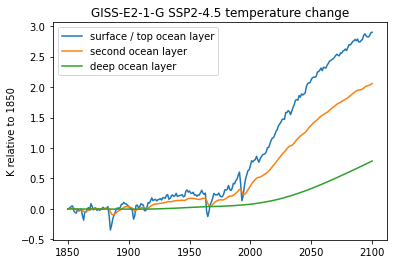

In [13]:
pl.plot(ebm.time, ebm.temperature[:,0], label='surface / top ocean layer')
pl.plot(ebm.time, ebm.temperature[:,1], label='second ocean layer')
pl.plot(ebm.time, ebm.temperature[:,2], label='deep ocean layer')
pl.ylabel('K relative to 1850')
pl.title('GISS-E2-1-G SSP2-4.5 temperature change')
pl.legend()

Text(0.5, 1.0, 'GISS-E2-1-G SSP2-4.5 change in OHC')

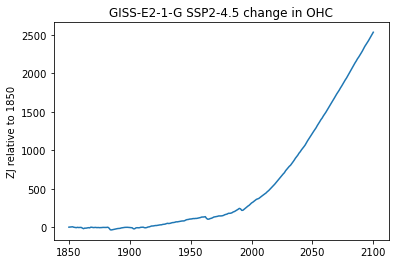

In [14]:
pl.plot(ebm.time, ebm.ocean_heat_content_change/10**21)
pl.ylabel('ZJ relative to 1850')
pl.title('GISS-E2-1-G SSP2-4.5 change in OHC')

Text(0.5, 1.0, 'GISS-E2-1-G SSP2-4.5 thermosteric sea level rise')

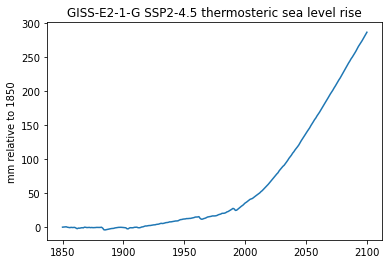

In [15]:
# A very, very crude estimate of global thermosteric sea level rise
# use Kuhlbrodt & Gregory 2012 multi-model-mean of 0.113 mm / ZJ thermal expansion coefficient

pl.plot(ebm.time, ebm.ocean_heat_content_change/10**21*0.113)
pl.ylabel('mm relative to 1850')
pl.title('GISS-E2-1-G SSP2-4.5 thermosteric sea level rise')

Text(0.5, 1.0, 'GISS-E2-1-G SSP2-4.5 TOA energy imbalance')

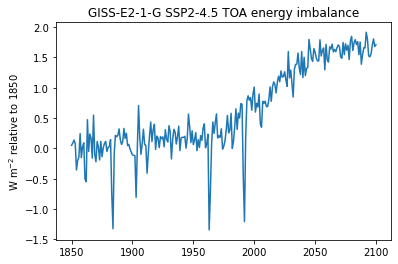

In [16]:
pl.plot(ebm.time, ebm.toa_imbalance)
pl.ylabel('W m$^{-2}$ relative to 1850')
pl.title('GISS-E2-1-G SSP2-4.5 TOA energy imbalance')

## Test with non-yearly timestep

For this I'll use the IPCC AR6 forcing, but interpolated to monthly and monthly volcanic forcing substituted in.

Use Donald Cummins' default parameters for the EBM.

In [17]:
df_volcanic = pd.read_csv(
    os.path.join("..", "data", "forcing", "volcanic_sAOD_monthly_175001-201912.csv"),
    index_col=0
)
df_volcanic

,stratospheric_AOD
year,
1750.041667,0.002912
1750.125000,0.002912
1750.208333,0.002912
1750.291667,0.002912
1750.375000,0.002911
...,...
2019.625000,0.006200
2019.708333,0.007017
2019.791667,0.007491


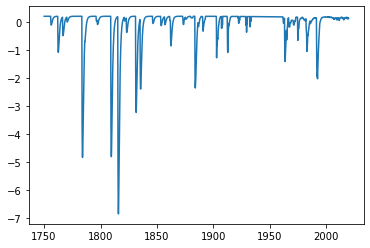

In [18]:
# see https://github.com/chrisroadmap/ar6/blob/main/notebooks/040_chapter2_volcanic_erf.ipynb
df_volcanic['forcing'] = df_volcanic['stratospheric_AOD'] * (-20) + 0.2582047762183514
pl.plot(df_volcanic['forcing'])

In [19]:
df_solar_anthro = pd.read_csv(
    os.path.join("..", "data", "forcing", "AR6_ERF_1750-2019_solar_anthro.csv"),
    index_col=0
)
df_solar_anthro

,solar,total_anthropogenic
year,,
1750,0.097590,0.000000
1751,0.079244,0.007408
1752,0.049166,0.012794
1753,0.012988,0.011676
1754,-0.021427,0.005655
...,...,...
2015,0.029197,2.473288
2016,-0.007587,2.556876
2017,-0.017467,2.617965


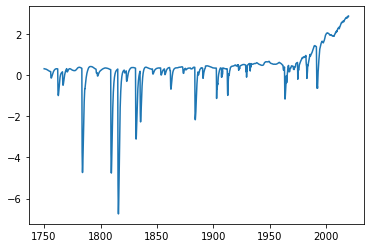

In [20]:
f = interp1d(np.arange(1750.5, 2020), df_solar_anthro['solar'], fill_value='extrapolate')
solar = f(np.arange(1750+1/24, 2020, 1/12))
f = interp1d(np.arange(1750.5, 2020), df_solar_anthro['total_anthropogenic'], fill_value='extrapolate')
anthro = f(np.arange(1750+1/24, 2020, 1/12))
ar6_forcing_monthly = solar + anthro + df_volcanic['forcing'].values
pl.plot(np.arange(1750+1/24, 2020, 1/12), ar6_forcing_monthly)

In [21]:
# run
ebm = EnergyBalanceModel()
ebm.add_forcing(forcing=ar6_forcing_monthly, time=np.arange(1750+1/24, 2020, 1/12))
ebm.run()

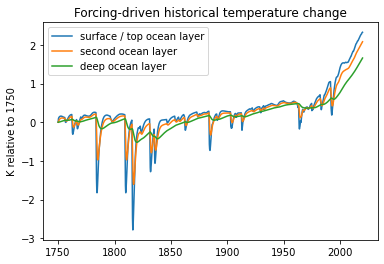

In [22]:
pl.plot(ebm.time, ebm.temperature[:,0], label='surface / top ocean layer')
pl.plot(ebm.time, ebm.temperature[:,1], label='second ocean layer')
pl.plot(ebm.time, ebm.temperature[:,2], label='deep ocean layer')
pl.ylabel('K relative to 1750')
pl.title('Forcing-driven historical temperature change')
pl.legend()

Text(0.5, 1.0, 'Forcing-driven change in OHC')

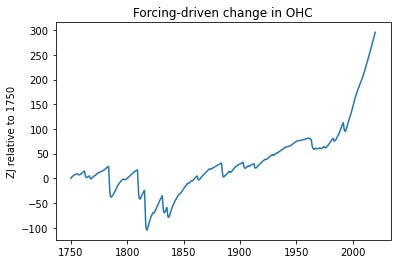

In [23]:
pl.plot(ebm.time, ebm.ocean_heat_content_change/10**21)
pl.ylabel('ZJ relative to 1750')
pl.title('Forcing-driven change in OHC')

Text(0.5, 1.0, 'Forcing-driven thermosteric sea level rise')

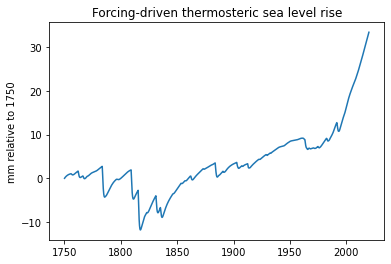

In [24]:
# A very, very crude estimate of global thermosteric sea level rise
# use Kuhlbrodt & Gregory 2012 multi-model-mean of 0.113 mm / ZJ thermal expansion coefficient

pl.plot(ebm.time, ebm.ocean_heat_content_change/10**21*0.113)
pl.ylabel('mm relative to 1750')
pl.title('Forcing-driven thermosteric sea level rise')

Text(0.5, 1.0, 'Forcing-driven TOA energy imbalance')

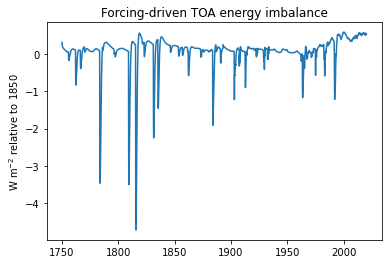

In [25]:
pl.plot(ebm.time, ebm.toa_imbalance)
pl.ylabel('W m$^{-2}$ relative to 1850')
pl.title('Forcing-driven TOA energy imbalance')

## Run RFMIP with their tuned scenarios

In [26]:
results = {}
rfmip_forcing = {}
models = ['CanESM5', 'CNRM-CM6-1', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'MIROC6']
runs = {}
for model in models:
    runs[model] = 'r1i1p1f1'
# exceptions
runs['CanESM5'] = 'r1i1p2f1'
runs['CNRM-CM6-1'] = 'r1i1p1f2'
runs['HadGEM3-GC31-LL'] = 'r1i1p1f3'
# no NorESM2 as we can't find a convergent three layer tuning... yet
# GFDL-CM4 also not in Zeb's data
# and no IPSL! I'm going to have to synda this

In [27]:
for model in models:
    rfmip_forcing[model] = df_forcing['%s TOT' % model].values
    ebm = EnergyBalanceModel(**params[model][runs[model]])
    ebm.emergent_parameters()
    ebm.add_forcing(forcing = rfmip_forcing[model], time=np.arange(1850, 2101))
    ebm.run()
    
    # TODO: method to easily save out results to an object or dict. Glen Harris's version had a nice Results class for this
    results[model] = ebm.__dict__

In [28]:
# this is what the combined input/output dict looks like
results[model]

{'ocean_heat_capacity': array([  4.11067654,  30.05806814, 332.33341946]),
 'ocean_heat_transfer': array([2.0315819 , 1.04725401, 0.53732622]),
 'deep_ocean_efficacy': 0.263217073227109,
 'forcing_4co2': 8.65392453995481,
 'stochastic_run': False,
 'sigma_eta': 0.700456280933403,
 'sigma_xi': 0.851583705091037,
 'gamma_autocorrelation': 1.78006025608583,
 'seed': None,
 'timescales': array([  1.31357053,  36.31542796, 752.97303519]),
 'response_coefficients': array([0.31419678, 0.14650216, 0.03152832]),
 'ecs': 2.0289110047143795,
 'tcr': 1.6117919724595198,
 'forcing': array([-0.04083551,  0.20029382,  0.12159428,  0.21244084,  0.14368871,
         0.10473653,  0.04573864,  0.14472967, -0.04368052, -0.039872  ,
         0.29256677, -0.16195218, -0.39535148, -0.08758128,  0.09325395,
         0.19915799,  0.28959974,  0.11634498,  0.11952446,  0.26065433,
         0.08332734,  0.14098188, -0.03277929,  0.05202797,  0.19900324,
         0.2303094 ,  0.25458461,  0.10375   ,  0.20793394,

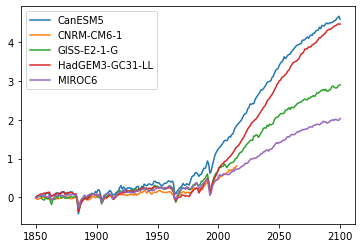

In [29]:
for model in models:
    pl.plot(np.arange(1850, 2101), results[model]['temperature'][:,0], label=model)
pl.legend()

In [30]:
for model in models:
    print(model, results[model]['ecs'], results[model]['tcr'])

CanESM5 5.669880933261653 2.7851567710705014
CNRM-CM6-1 3.225231389145626 2.509711128432663
GISS-E2-1-G 2.6215754524261183 1.6801454609795394
HadGEM3-GC31-LL 5.6324302018994645 2.7047285657158455
MIROC6 2.0289110047143795 1.6117919724595198


### Compare to each model's CMIP6 ScenarioMIP SSP2-4.5

In [31]:
df = pd.read_csv(os.path.join("..", "data", "netcdf-scm", "ssp245.csv"))
df
# I only want certain i, p, f combinations of some models
filters = {
    'CanESM5': 'i1p2f1',
    'CNRM-CM6-1': 'i1p1f2',
    'GISS-E2-1-G': 'i1p1f2',
    'HadGEM3-GC31-LL': 'i1p1f3',
    'MIROC6': 'i1p1f1'   
}

cmip6 = {}

for model in models:
    condition = (df['climate_model']==model) & df['member_id'].str.contains(filters[model]) & (df['variable']=='tas')
    cmip6[model] = {}
    cmip6[model]['tas'] = df.loc[condition].values[:,9:]
    condition = (df['climate_model']==model) & df['member_id'].str.contains(filters[model]) & (df['variable']=='rndt')
    cmip6[model]['rndt'] = df.loc[condition].values[:,9:]

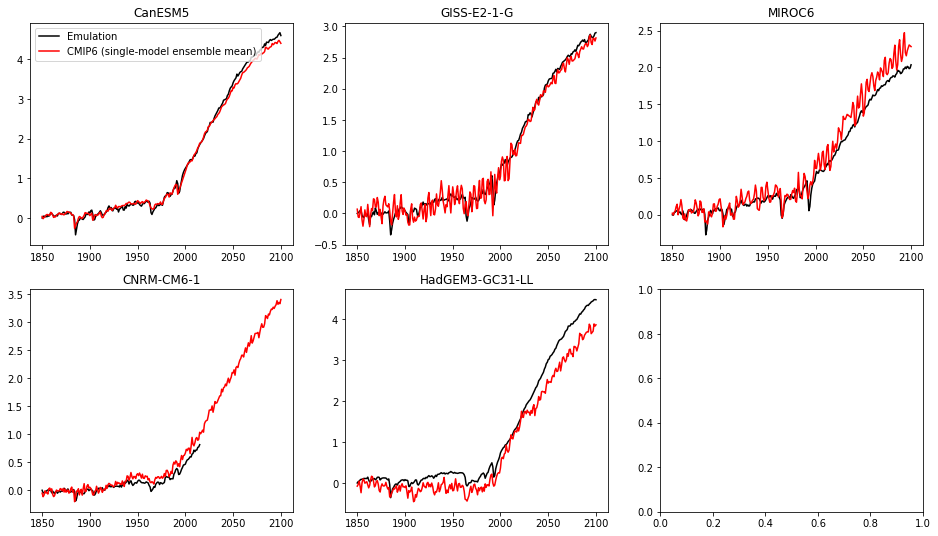

In [32]:
fig, ax = pl.subplots(2,3, figsize=(16, 9))
for i, model in enumerate(models):
    ax[i%2,i//2].plot(np.arange(1850, 2101), results[model]['temperature'][:,0], color='k', label='Emulation')
    #ax[0,0].fill_between(np.arange(1850, 2101), np.min(cmip6[model]['tas'], axis=0), np.max(cmip6[model]['tas'], axis=0), color='r', alpha=0.3)
    ax[i%2,i//2].plot(np.arange(1850, 2101), cmip6[model]['tas'].mean(axis=0), color='r', label='CMIP6 (single-model ensemble mean)')
    ax[i%2,i//2].set_title(model)
ax[0,0].legend()

In [33]:
# I want to see what an ensemble looks like!
n_ens = 100

ens = {}
for im, model in tqdm(enumerate(models)):
    ens[model] = {}
    for i in tqdm(range(n_ens), leave=True):
        params[model]['seed'] = im*1000+i
        ebm = EnergyBalanceModel(stochastic_run=True, **params[model][runs[model]])
        ebm.add_forcing(forcing = rfmip_forcing[model], time=np.arange(1850, 2101))
        ebm.run()
    
        # TODO: method to easily save out results to an object or dict. Glen Harris's version had a nice Results class for this
        ens[model][i] = ebm.__dict__

0it [00:00, ?it/s]
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 120.71it/s]
1it [00:00,  1.18it/s]
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 139.89it/s]
2it [00:01,  1.29it/s]
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 149.51it/s]
3it [00:02,  1.37it/s]
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 158.29it/s]
4it [00:02,  1.44it/s]
100%|████████████████████████████████████████| 100/100 [00:00<00:00, 132.42it/s]
5it [00:03,  1.37it/s]


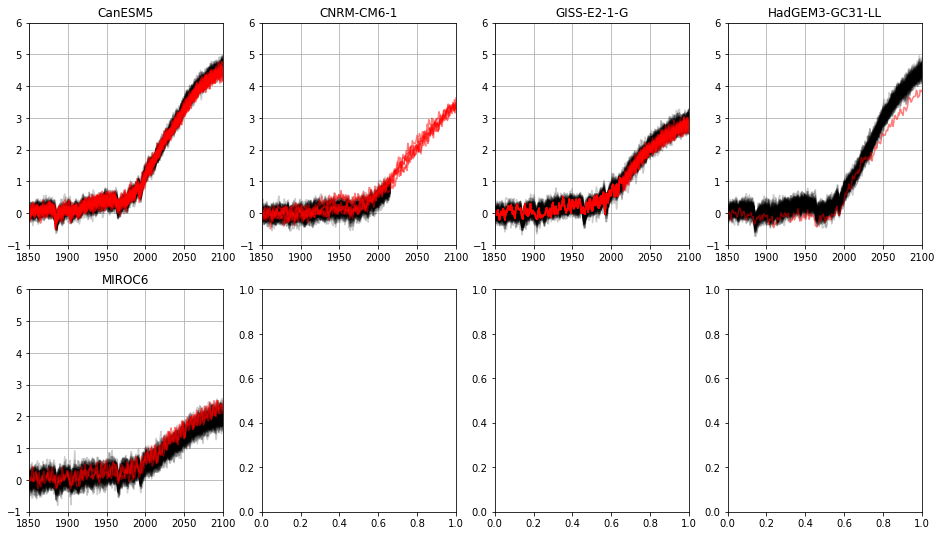

In [34]:
fig, ax = pl.subplots(2,4, figsize=(16,9))
for im, model in enumerate(models):
    for i in range(n_ens):
        ax[im//4,im%4].plot(np.arange(1850, 2101), ens[model][i]['temperature'][:,0], color='k', alpha=0.2)
    #for run in branch_points['historical'][model]:
    ax[im//4,im%4].plot(np.arange(1850, 2101), cmip6[model]['tas'].T, color='r', alpha=0.5)
    ax[im//4,im%4].set_xlim(1850,2100)
    ax[im//4,im%4].set_ylim(-1,6)
    ax[im//4,im%4].grid()
    ax[im//4,im%4].set_title(model)

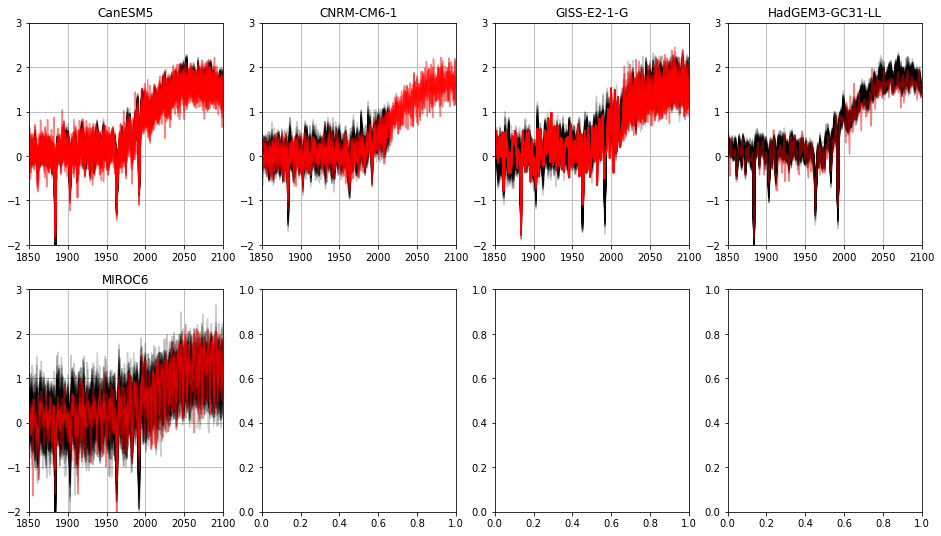

In [35]:
fig, ax = pl.subplots(2,4, figsize=(16,9))
for im, model in enumerate(models):
    for i in range(n_ens):
        ax[im//4,im%4].plot(np.arange(1850, 2101), ens[model][i]['toa_imbalance'], color='k', alpha=0.2)
    ax[im//4,im%4].plot(np.arange(1850, 2101), cmip6[model]['rndt'].T, color='r', alpha=0.5)
    ax[im//4,im%4].set_xlim(1850,2100)
    ax[im//4,im%4].set_ylim(-2,3)
    ax[im//4,im%4].grid()
    ax[im//4,im%4].set_title(model)

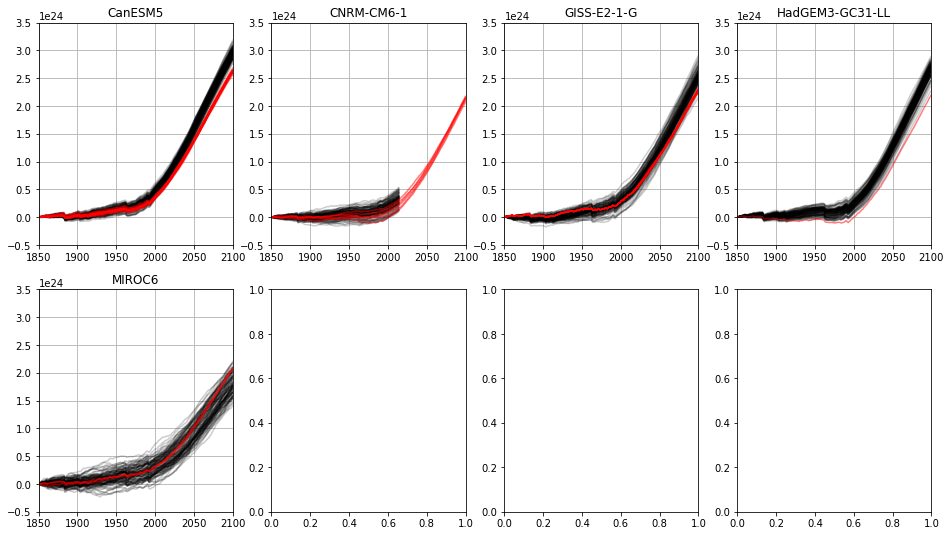

In [36]:
fig, ax = pl.subplots(2,4, figsize=(16,9))
for im, model in enumerate(models):
    for i in range(n_ens):
        ax[im//4,im%4].plot(np.arange(1850, 2101), ens[model][i]['ocean_heat_content_change'], color='k', alpha=0.2)
    ax[im//4,im%4].plot(np.arange(1850, 2101), np.cumsum(cmip6[model]['rndt'].T, axis=0) * EARTH_RADIUS**2 * 4 * np.pi * SECONDS_PER_YEAR, color='r', alpha=0.5)
    ax[im//4,im%4].set_xlim(1850,2100)
    ax[im//4,im%4].set_ylim(-5e23, 3.5e24)
    ax[im//4,im%4].grid()
    ax[im//4,im%4].set_title(model)